In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
from tqdm.auto import tqdm
import pickle
import os
from run_functions import *
from agent_functions import *
from plot_functions import *
from routing_networks import *
from recommenders import *
import math
#import nolds
#import sklearn

game properties:
- number of players
    - fixed
    - variable
- number of actions
    - fixed
    - variable
- state space
    - size
- reward 
    - max
    - min

# Duopoly

In [2]:
def duopoly(a1, a2, n_actions=6):
    
    p1 = a1/n_actions
    p2 = a2/n_actions
    
    if p1 < p2:
        r1 = (1 - p1)*p1
        r2 = 0
    if p1 == p2:
        r1 = 0.5*(1 - p1)
        r2 = r1
    if p1 > p2:
        r1 = 0
        r2 = (1 - p2)*p2
    
    R = np.array([r1, r2])
    S = np.array([a2, a1])
    
    return R, S

In [3]:
%%time
def run_duopoly(EPSILON=0):
    # Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)
    Q = np.random.random((N_AGENTS, N_STATES, N_ACTIONS))

    ALPHA = np.random.random_sample(size=N_AGENTS)

    if EPSILON == "UNIFORM":
        EPSILON = np.random.random_sample(size=N_AGENTS) * mask
    else:
        EPSILON = EPSILON * np.ones(N_AGENTS) * mask

    EPS_START = EPSILON
    EPS_END = EPSILON
    EPS_DECAY = N_ITER/8

    M = {}
    ind = np.arange(N_AGENTS)
    S = np.random.randint(N_STATES, size=N_AGENTS)
    R = np.ones(N_AGENTS) * -2
    A = np.random.randint(N_STATES, size=N_AGENTS)
    action1 = A[0]
    action2 = A[1]

    elist = []

    for t in range(N_ITER):

        EPSILON = (EPS_END + (EPS_START - EPS_END) * math.exp(-1. * t / EPS_DECAY)) # if t < N_ITER/10 else 0
        elist.append(EPSILON)

        A = e_greedy_select_action(Q, S, EPSILON)
        
        if t%2 == 0:
            action1 = A[0]
        else:
            action2 = A[1]
        
        R, S = duopoly(a1=action1, a2=action2, n_actions=N_ACTIONS)
        
        Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)

        ### SAVE PROGRESS DATA
        M[t] = {"nA": np.bincount(A, minlength=3),
                "R": R,
                "Qmean": Q.mean(axis=1).mean(axis=0),
                #"groups": count_groups(Q[ind, S, :], 0.1),
                "Qvar": Q[ind, S, :].var(axis=0),
                "nA": np.bincount(A, minlength=3),
                # "T": travel_time_per_route,
                "sum_of_belief_updates": sum_of_belief_updates,
                #"alignment": alignment,
                #"recommendation_alignment": recommendation_alignment,
                #"action_alignment": action_alignment,
                }
    return M, elist

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.01 µs


In [6]:
N_AGENTS = 2
N_STATES = 24
N_ACTIONS = N_STATES
N_ITER = 10000

EPSILON = 0.7
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0.8
ALPHA = 0.01

QINIT = "UNIFORM" # np.array([-1.5, -1.5, -1.5])

Text(0, 0.5, 'welfare')

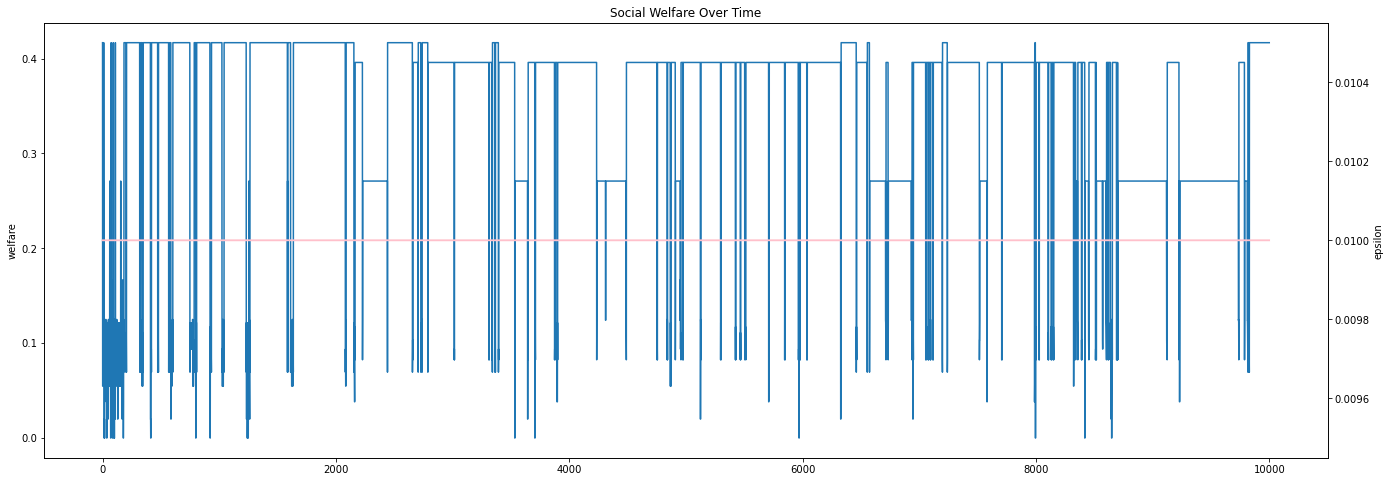

In [7]:
M, elist = run_duopoly(0.01)
fig, ax = plt.subplots(figsize=(23,8))
ax.plot([M[t]["R"].mean() for t in M.keys()])
ax2=ax.twinx()
ax2.plot(elist, color='pink')
ax2.set_ylabel("epsilon")
plt.title("Social Welfare Over Time")
plt.xlabel("iteration")
ax.set_ylabel("welfare")
#ax.set_ylim((0,0.5))

In [21]:
results_dict = {}

for epsilon in tqdm(np.linspace(0, 1, 101)):
    repetitions = {}
    for i in range(10):
        M, elist = run(epsilon)
        repetitions[i] = np.array([M[t]["R"].mean() for t in M.keys()])
    results_dict[epsilon] = repetitions

  0%|          | 0/101 [00:00<?, ?it/s]

In [22]:
path = "dynamics_results"
name = "duopoly_q-learning_epsilon-sweep_alpha01_gamma8"

In [23]:
epsilons = np.linspace(0, 1, 101)
ind1, ind2 = -5000, -1
means = np.array([np.array([x[ind1:ind2].mean() for x in dictionary.values()]).mean() for dictionary in results_dict.values()])
q25 = np.array([np.percentile(np.array([x[ind1:ind2].mean() for x in dictionary.values()]), 25) for dictionary in results_dict.values()])
q75 = np.array([np.percentile(np.array([x[ind1:ind2].mean() for x in dictionary.values()]), 75) for dictionary in results_dict.values()])

In [ ]:
lyapunov = np.array([np.array([nolds.lyap_r(x[ind1:ind2]) for x in dictionary.values()]).mean() for dictionary in results_dict.values()])

FileNotFoundError: [Errno 2] No such file or directory: 'dynamics_results/welfare_duopoly_q-learning_epsilon-sweep_alpha01_gamma8.png'

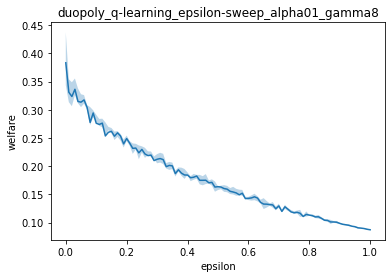

In [24]:
plt.plot(epsilons, means)
plt.fill_between(epsilons, q25, q75, alpha=0.3)
plt.title(name)
plt.ylabel("welfare")
plt.xlabel("epsilon")
plt.savefig(f"{path}/welfare_{name}.png")

In [ ]:
plt.plot(epsilons, lyapunov)
# plt.fill_between(epsilons, q25, q75, alpha=0.3)

In [ ]:
# DUMP
with open(f"dynamics_results/{name}", "wb") as file:
    pickle.dump(results_dict, file)

In [ ]:
# LOAD
with open(f"{path}/{name}", "rb") as file:
    results_dict = pickle.load(file)

# Prisoners Dilemma

In [9]:
def prisoners_dilemma(a1, a2, r, s):
    if a1 == 0 and a2 == 0:
        r1 = r
        r2 = r
    elif a1 == 0 and a2 == 1:
        r1 = -s
        r2 = 1
    elif a1 == 1 and a2 == 0:
        r1 = 1
        r2 = -s
    elif a1 == 1 and a2 == 1:
        r1 = 0
        r2 = 0
    
    state = a1 + a2
    
    R = np.array([r1, r2])
    S = np.array([state, state])
    
    return R, S

In [18]:
%%time
def run_prisoners(EPSILON=0):
    # Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)
    Q = np.random.random((N_AGENTS, N_STATES, N_ACTIONS)) - 0.5

    ALPHA = np.random.random_sample(size=N_AGENTS)

    if EPSILON == "UNIFORM":
        EPSILON = np.random.random_sample(size=N_AGENTS) * mask
    else:
        EPSILON = EPSILON * np.ones(N_AGENTS) * mask

    EPS_START = EPSILON
    EPS_END = EPSILON
    EPS_DECAY = N_ITER/8

    M = {}
    ind = np.arange(N_AGENTS)
    S = np.random.randint(N_STATES, size=N_AGENTS)
    R = np.ones(N_AGENTS) * -2
    A = np.random.randint(N_STATES, size=N_AGENTS)
    action1 = A[0]
    action2 = A[1]

    elist = []

    for t in range(N_ITER):

        EPSILON = (EPS_END + (EPS_START - EPS_END) * math.exp(-1. * t / EPS_DECAY)) # if t < N_ITER/10 else 0
        elist.append(EPSILON)

        A = e_greedy_select_action(Q, S, EPSILON)
        
        action1 = A[0]
        action2 = A[1]
        
        R, S = prisoners_dilemma(a1=action1, a2=action2, r=0.5, s=0.5)
        
        Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)

        ### SAVE PROGRESS DATA
        M[t] = {"nA": np.bincount(A, minlength=3),
                "R": R,
                "Qmean": Q.mean(axis=1).mean(axis=0),
                #"groups": count_groups(Q[ind, S, :], 0.1),
                "Qvar": Q[ind, S, :].var(axis=0),
                "nA": np.bincount(A, minlength=3),
                # "T": travel_time_per_route,
                "sum_of_belief_updates": sum_of_belief_updates,
                #"alignment": alignment,
                #"recommendation_alignment": recommendation_alignment,
                #"action_alignment": action_alignment,
                }
    return M, elist

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 14.1 µs


In [17]:
N_AGENTS = 2
N_STATES = 4
N_ACTIONS = 2
N_ITER = 10000

EPSILON = 0.05
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0.8
ALPHA = 0.01

QINIT = "UNIFORM" # np.array([-1.5, -1.5, -1.5])

Text(0, 0.5, 'welfare')

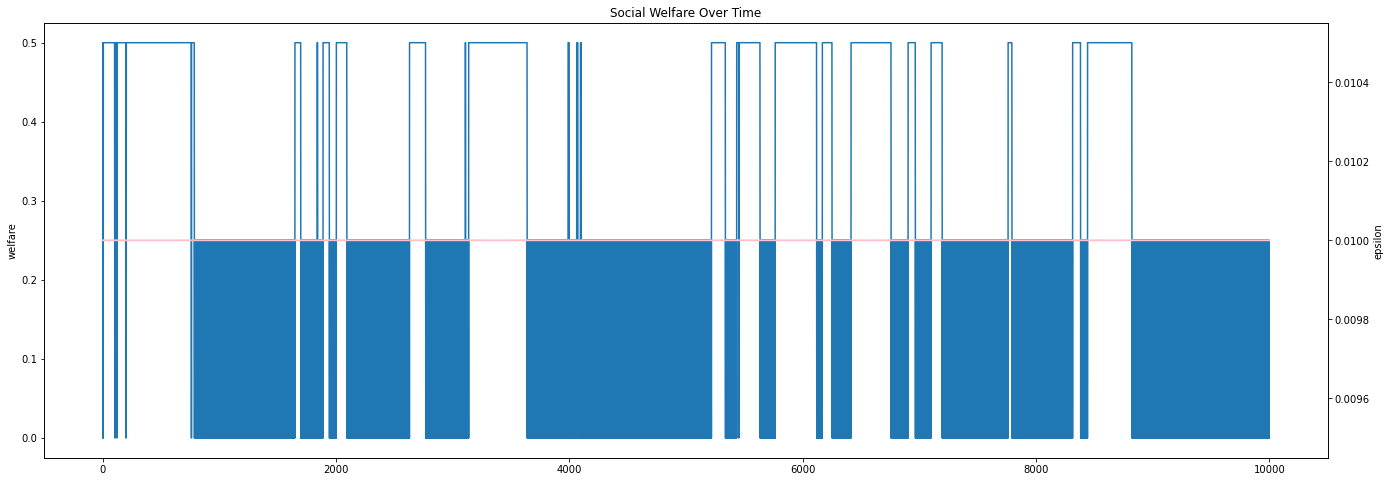

In [19]:
M, elist = run_prisoners(0.01)
fig, ax = plt.subplots(figsize=(23,8))
ax.plot([M[t]["R"].mean() for t in M.keys()])
ax2=ax.twinx()
ax2.plot(elist, color='pink')
ax2.set_ylabel("epsilon")
plt.title("Social Welfare Over Time")
plt.xlabel("iteration")
ax.set_ylabel("welfare")
#ax.set_ylim((0,0.5))

In [ ]:
results_dict = {}

for epsilon in tqdm(np.linspace(0, 1, 101)):
    repetitions = {}
    for i in range(10):
        M, elist = run(epsilon)
        repetitions[i] = np.array([M[t]["R"].mean() for t in M.keys()])
    results_dict[epsilon] = repetitions

In [ ]:
path = "dynamics_results"
name = "prisoners_q-learning_epsilon-sweep_alpha01"

In [ ]:
with open(f"{path}/{name}", "rb") as file:
    results_dict = pickle.load(file)

In [ ]:
epsilons = np.linspace(0, 1, 101)
ind1, ind2 = -5000, -1
means = np.array([np.array([x[ind1:ind2].mean() for x in dictionary.values()]).mean() for dictionary in results_dict.values()])
q25 = np.array([np.percentile(np.array([x[ind1:ind2].mean() for x in dictionary.values()]), 25) for dictionary in results_dict.values()])
q75 = np.array([np.percentile(np.array([x[ind1:ind2].mean() for x in dictionary.values()]), 75) for dictionary in results_dict.values()])

In [ ]:
lyapunov = np.array([np.array([nolds.lyap_r(x[ind1:ind2]) for x in dictionary.values()]).mean() for dictionary in results_dict.values()])

In [ ]:
plt.plot(epsilons, means)
plt.fill_between(epsilons, q25, q75, alpha=0.3)
plt.title(name)
plt.ylabel("welfare")
plt.xlabel("epsilon")
plt.savefig(f"{path}/welfare_{name}.png")

In [ ]:
plt.plot(epsilons, lyapunov)
# plt.fill_between(epsilons, q25, q75, alpha=0.3)

In [ ]:
with open(f"dynamics_results/{name}", "wb") as file:
    pickle.dump(results_dict, file)

# Population Game

In [98]:
def population_game(A, V=2, K=1, exponent=2, cost=0.5):
    n_players = len(A)
    fraction_weak = (A==0).sum()/n_players
    fraction_strong = (A==1).sum()/n_players
    
    utility_weak = V * (fraction_weak*K)**(exponent-1) - cost
    utility_strong = V * (fraction_strong*K)**(exponent-1)  # no added cost
    
    T = [utility_weak, utility_strong]
    R = np.array([T[a] for a in A])
    return R, T

In [144]:
%%time
def run_population_game(EPSILON=0):
    Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)
    # Q = np.random.random((N_AGENTS, N_STATES, N_ACTIONS)) * 2

    ALPHA = np.random.random_sample(size=N_AGENTS)

    if EPSILON == "UNIFORM":
        EPSILON = np.random.random_sample(size=N_AGENTS) * mask
    else:
        EPSILON = EPSILON * np.ones(N_AGENTS) * mask

    EPS_START = EPSILON
    EPS_END = EPSILON
    EPS_DECAY = N_ITER/8

    M = {}
    ind = np.arange(N_AGENTS)
    S = np.random.randint(N_STATES, size=N_AGENTS)
    R = np.ones(N_AGENTS) * -2
    A = np.random.randint(N_STATES, size=N_AGENTS)

    elist = []

    for t in range(N_ITER):

        EPSILON = (EPS_END + (EPS_START - EPS_END) * math.exp(-1. * t / EPS_DECAY)) # if t < N_ITER/10 else 0
        elist.append(EPSILON)

        A = e_greedy_select_action(Q, S, EPSILON)
        
        R, T = population_game(A, V=2, K=1, exponent=2, cost=0.5)

        Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)

        ### SAVE PROGRESS DATA
        M[t] = {"nA": np.bincount(A, minlength=3),
                "R": R,
                "Qmean": Q.mean(axis=1).mean(axis=0),
                #"groups": count_groups(Q[ind, S, :], 0.1),
                "Qvar": Q[ind, S, :].var(axis=0),
                "nA": np.bincount(A, minlength=3),
                # "T": travel_time_per_route,
                "sum_of_belief_updates": sum_of_belief_updates,
                #"alignment": alignment,
                #"recommendation_alignment": recommendation_alignment,
                #"action_alignment": action_alignment,
                }
    return M, elist

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 14.8 µs


In [153]:
N_AGENTS = 100
N_STATES = 1
N_ACTIONS = 2
N_ITER = 5000

EPSILON = 0.3
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0.8
ALPHA = 0.01

QINIT = "UNIFORM" # np.array([-1.5, -1.5, -1.5])
QINIT = np.array([2, 0])
# QINIT = np.random.random((N_AGENTS, N_STATES, N_ACTIONS)) * 2

(1.0, 2.0)

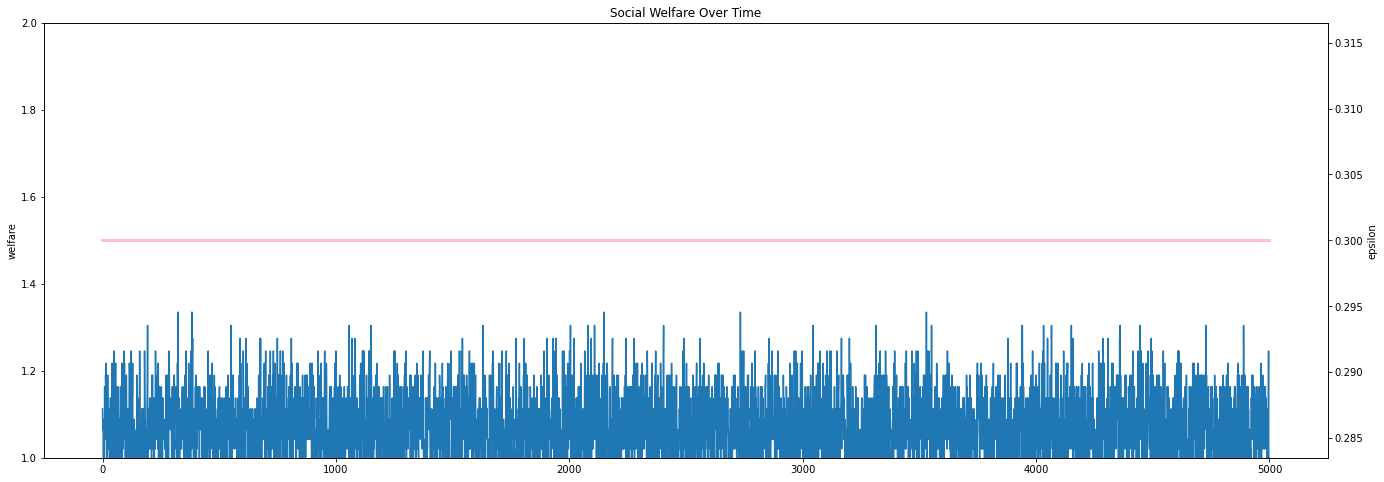

In [154]:
M, elist = run_population_game(0.3)
fig, ax = plt.subplots(figsize=(23,8))
ax.plot([M[t]["R"].mean() for t in M.keys()])
ax2=ax.twinx()
ax2.plot(elist, color='pink')
ax2.set_ylabel("epsilon")
plt.title("Social Welfare Over Time")
plt.xlabel("iteration")
ax.set_ylabel("welfare")
ax.set_ylim((1,2))

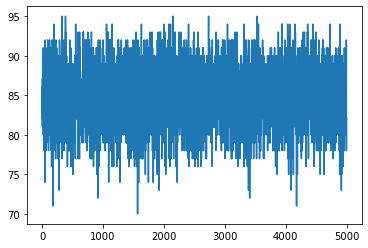

In [155]:
plt.plot([M[t]["nA"][0] for t in M.keys()])

# Two Route Game

In [226]:
def two_route_game(A, balance_parameter):
    n_players = len(A)
    fraction_a = (A==0).sum()/n_players
    fraction_b = 1 - fraction_a
    
    travel_time_a = fraction_a + balance_parameter
    travel_time_b = fraction_b + (1 - balance_parameter)
    
    T = [-travel_time_a, -travel_time_b]
    R = np.array([T[a] for a in A])
    return R, T

$$average = a * ta + b * tb = a^2 + ap + (1-a)^2 + (1-a)(1-p)$$
$$ a^2 + ap + 1 - 2a + a^2 + 1 - a - p + ap $$
$$ 2a^2 + 2ap - 2a + 2 $$
$$ 2a^2 + 2ap - 2a + 2 = 0$$
$$ a^2 + ap - a + 1 = 0$$
$$ a^2 + (p-1)a + 1 = 0$$
$$ -(p-1) +- sqrt((p-1)^2 - 4) / 2 $$

$$(a^2+1)/a = 1-p$$
$$1 - (a^2+1)/a=p$$
$ p = 0.1, (a^2+1)/a = 0.9$
$(a^2+1)/a = 0.9$
$(a^2+1) = a 0.9$
$(a^2+1) - 0.9a = 0$
$$ (0.9 +- \sqrt(0.9^2-4))/2 $$

In [227]:
%%time
def run_two_route_game(EPSILON=0, BALANCE=1):
    Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)
    # Q = np.random.random((N_AGENTS, N_STATES, N_ACTIONS)) * 2

    ALPHA = np.random.random_sample(size=N_AGENTS)

    if EPSILON == "UNIFORM":
        EPSILON = np.random.random_sample(size=N_AGENTS) * mask
    else:
        EPSILON = EPSILON * np.ones(N_AGENTS) * mask

    EPS_START = EPSILON
    EPS_END = EPSILON
    EPS_DECAY = N_ITER/8

    M = {}
    ind = np.arange(N_AGENTS)
    S = np.random.randint(N_STATES, size=N_AGENTS)
    R = np.ones(N_AGENTS) * -2
    A = np.random.randint(N_STATES, size=N_AGENTS)

    elist = []

    for t in range(N_ITER):

        EPSILON = (EPS_END + (EPS_START - EPS_END) * math.exp(-1. * t / EPS_DECAY)) # if t < N_ITER/10 else 0
        elist.append(EPSILON)

        A = e_greedy_select_action(Q, S, EPSILON)
        
        R, T = two_route_game(A, balance_parameter=BALANCE)
            
        Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)

        ### SAVE PROGRESS DATA
        M[t] = {"nA": np.bincount(A, minlength=3),
                "R": R,
                "Qmean": Q.mean(axis=1).mean(axis=0),
                #"groups": count_groups(Q[ind, S, :], 0.1),
                "Qvar": Q[ind, S, :].var(axis=0),
                # "T": travel_time_per_route,
                "sum_of_belief_updates": sum_of_belief_updates,
                #"alignment": alignment,
                #"recommendation_alignment": recommendation_alignment,
                #"action_alignment": action_alignment,
                }
    return M, elist

CPU times: user 15 µs, sys: 1 µs, total: 16 µs
Wall time: 21 µs


In [228]:
N_AGENTS = 100
N_STATES = 1
N_ACTIONS = 2
N_ITER = 100

EPSILON = 0.3
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0.8
ALPHA = 0.01

QINIT = "UNIFORM" # np.array([-1.5, -1.5, -1.5])
QINIT = np.array([2, 0])
# QINIT = np.random.random((N_AGENTS, N_STATES, N_ACTIONS)) * 2

(-0.5, -1.5)

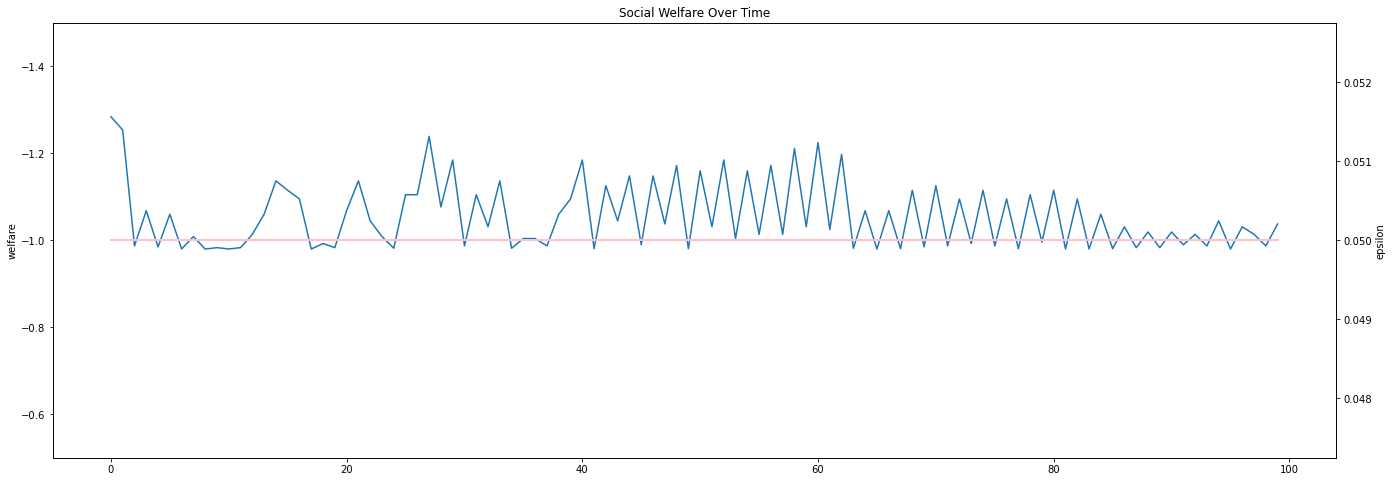

In [231]:
M, elist = run_two_route_game(0.05, 0.3)
fig, ax = plt.subplots(figsize=(23,8))
ax.plot([M[t]["R"].mean() for t in M.keys()])
ax2=ax.twinx()
ax2.plot(elist, color='pink')
ax2.set_ylabel("epsilon")
plt.title("Social Welfare Over Time")
plt.xlabel("iteration")
ax.set_ylabel("welfare")
ax.set_ylim((-0.5,-1.5))

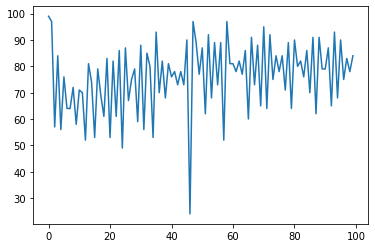

In [223]:
plt.plot([M[t]["nA"][0] for t in M.keys()])

In [182]:
results_dict = {}

for x in tqdm(np.linspace(0, 1, 101)):
    repetitions = {}
    for i in range(10):
        M, elist = run_two_route_game(EPSILON=0.05, BALANCE=x)
        repetitions[i] = np.array([M[t]["R"].mean() for t in M.keys()])
    results_dict[x] = repetitions

  0%|          | 0/101 [00:00<?, ?it/s]

In [183]:
path = "dynamics_results"
name = "two_route_q-learning_balance-sweep_alpha01_epsilon05"

In [184]:
x_values = np.linspace(0, 1, 101)
ind1, ind2 = -2500, -1
means = np.array([np.array([x[ind1:ind2].mean() for x in dictionary.values()]).mean() for dictionary in results_dict.values()])
q25 = np.array([np.percentile(np.array([x[ind1:ind2].mean() for x in dictionary.values()]), 25) for dictionary in results_dict.values()])
q75 = np.array([np.percentile(np.array([x[ind1:ind2].mean() for x in dictionary.values()]), 75) for dictionary in results_dict.values()])

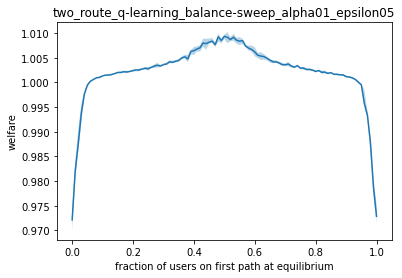

In [188]:
plt.plot(x_values, -means)
plt.fill_between(epsilons, -q25, -q75, alpha=0.3)
plt.title(name)
plt.ylabel("welfare")
plt.xlabel("fraction of users on first path at equilibrium")
plt.savefig(f"{path}/welfare_{name}.png")

In [ ]:
with open(f"dynamics_results/{name}", "wb") as file:
    pickle.dump(results_dict, file)

# Minority Game

In [2]:
%%time
def run_minority_game(EPSILON=0, BALANCE=1):
    Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)
    # Q = np.random.random((N_AGENTS, N_STATES, N_ACTIONS)) * 2

    ALPHA = np.random.random_sample(size=N_AGENTS)

    if EPSILON == "DECAYED":
        EPS_START = 1
        EPS_END = 0
        EPS_DECAY = N_ITER/8
    else:
        EPS_START = EPSILON
        EPS_END = EPSILON
        EPS_DECAY = N_ITER/8

    M = {}
    ind = np.arange(N_AGENTS)
    S = np.random.randint(N_STATES, size=N_AGENTS)
    R = np.ones(N_AGENTS) * -2
    A = np.random.randint(N_STATES, size=N_AGENTS)

    elist = []

    for t in range(N_ITER):

        EPSILON = (EPS_END + (EPS_START - EPS_END) * math.exp(-1. * t / EPS_DECAY)) # if t < N_ITER/10 else 0
        elist.append(EPSILON)

        A = e_greedy_select_action(Q, S, EPSILON)
        
        R, T = minority_game_2(A)
            
        Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)

        ### SAVE PROGRESS DATA
        M[t] = {"nA": np.bincount(A, minlength=3),
                "R": R,
                "Qmean": Q.mean(axis=1).mean(axis=0),
                #"groups": count_groups(Q[ind, S, :], 0.1),
                "Qvar": Q[ind, S, :].var(axis=0),
                # "T": travel_time_per_route,
                "sum_of_belief_updates": sum_of_belief_updates,
                #"alignment": alignment,
                #"recommendation_alignment": recommendation_alignment,
                #"action_alignment": action_alignment,
                }
    return M, elist

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [3]:
N_AGENTS = 100
N_STATES = 1
N_ACTIONS = 2
N_ITER = 10000

EPSILON = 0.3
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0.8
ALPHA = 0.01

QINIT = "UNIFORM" # np.array([-1.5, -1.5, -1.5])
QINIT = np.array([2, 0])
# QINIT = np.random.random((N_AGENTS, N_STATES, N_ACTIONS)) * 2

Text(0, 0.5, 'welfare')

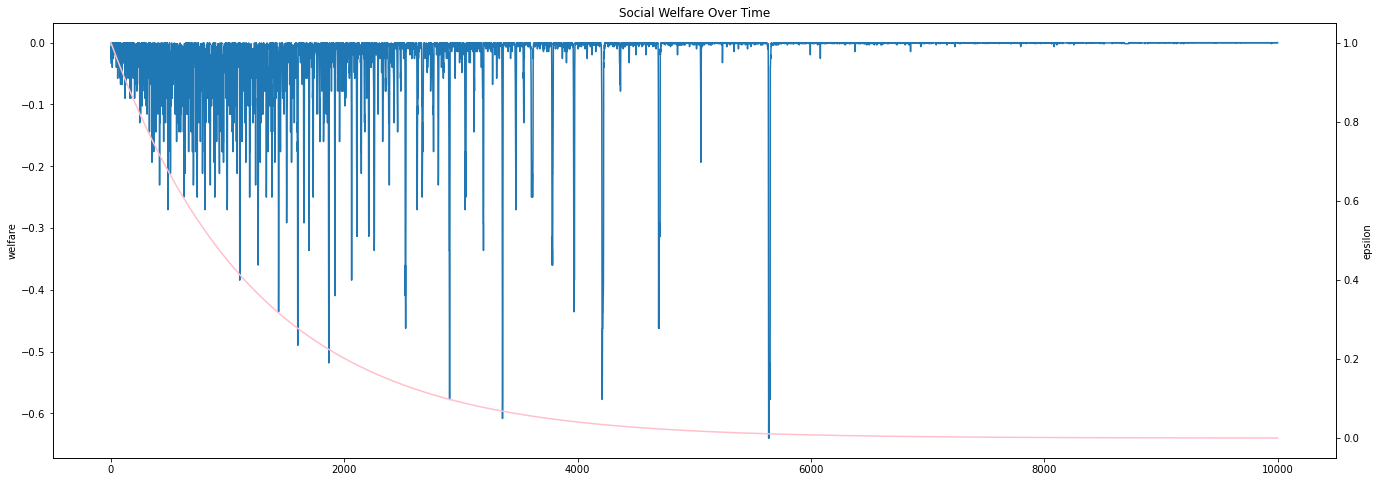

In [8]:
M, elist = run_minority_game("DECAYED", 0.3)
fig, ax = plt.subplots(figsize=(23,8))
ax.plot([M[t]["R"].mean() for t in M.keys()])
ax2=ax.twinx()
ax2.plot(elist, color='pink')
ax2.set_ylabel("epsilon")
plt.title("Social Welfare Over Time")
plt.xlabel("iteration")
ax.set_ylabel("welfare")
# ax.set_ylim((-0.5,-1.5))

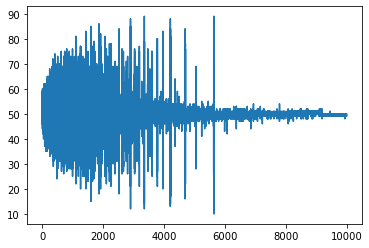

In [9]:
plt.plot([M[t]["nA"][0] for t in M.keys()])

In [182]:
results_dict = {}

for x in tqdm(np.linspace(0, 1, 101)):
    repetitions = {}
    for i in range(10):
        M, elist = run_two_route_game(EPSILON=0.05, BALANCE=x)
        repetitions[i] = np.array([M[t]["R"].mean() for t in M.keys()])
    results_dict[x] = repetitions

  0%|          | 0/101 [00:00<?, ?it/s]

In [183]:
path = "dynamics_results"
name = "two_route_q-learning_balance-sweep_alpha01_epsilon05"

In [184]:
x_values = np.linspace(0, 1, 101)
ind1, ind2 = -2500, -1
means = np.array([np.array([x[ind1:ind2].mean() for x in dictionary.values()]).mean() for dictionary in results_dict.values()])
q25 = np.array([np.percentile(np.array([x[ind1:ind2].mean() for x in dictionary.values()]), 25) for dictionary in results_dict.values()])
q75 = np.array([np.percentile(np.array([x[ind1:ind2].mean() for x in dictionary.values()]), 75) for dictionary in results_dict.values()])

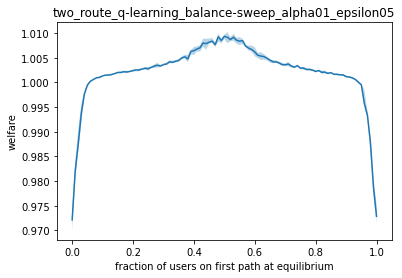

In [188]:
plt.plot(x_values, -means)
plt.fill_between(epsilons, -q25, -q75, alpha=0.3)
plt.title(name)
plt.ylabel("welfare")
plt.xlabel("fraction of users on first path at equilibrium")
plt.savefig(f"{path}/welfare_{name}.png")

In [ ]:
with open(f"dynamics_results/{name}", "wb") as file:
    pickle.dump(results_dict, file)

# Pigou

In [40]:
def pigou(A):
    n_agents = len(A)
    n_up = (A == 0).sum()
    n_down = (A == 1).sum()
    pct = n_down / n_agents

    r_0 = 1
    r_1 = pct

    T = [-r_0, -r_1]

    R = np.array([T[a] for a in A])  # -1 * np.vectorize(dict_map.get)(A)
    return R, T

In [41]:
%%time
def run_pigou_game(EPSILON=0, BALANCE=1):
    Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)
    # Q = np.random.random((N_AGENTS, N_STATES, N_ACTIONS)) * 2

    ALPHA = np.random.random_sample(size=N_AGENTS)

    if EPSILON == "DECAYED":
        EPS_START = 1
        EPS_END = 0
        EPS_DECAY = N_ITER/8
    else:
        EPS_START = EPSILON
        EPS_END = EPSILON
        EPS_DECAY = N_ITER/8

    M = {}
    ind = np.arange(N_AGENTS)
    S = np.random.randint(N_STATES, size=N_AGENTS)
    R = np.ones(N_AGENTS) * -2
    A = np.random.randint(N_STATES, size=N_AGENTS)

    elist = []

    for t in range(N_ITER):

        EPSILON = (EPS_END + (EPS_START - EPS_END) * math.exp(-1. * t / EPS_DECAY)) # if t < N_ITER/10 else 0
        elist.append(EPSILON)

        A = e_greedy_select_action(Q, S, EPSILON)
        
        R, T = pigou(A)
            
        Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)

        ### SAVE PROGRESS DATA
        M[t] = {"nA": np.bincount(A, minlength=3),
                "R": R,
                "Qmean": Q.mean(axis=1).mean(axis=0),
                #"groups": count_groups(Q[ind, S, :], 0.1),
                "Qvar": Q[ind, S, :].var(axis=0),
                # "T": travel_time_per_route,
                "sum_of_belief_updates": sum_of_belief_updates,
                #"alignment": alignment,
                #"recommendation_alignment": recommendation_alignment,
                #"action_alignment": action_alignment,
                }
    return M, elist

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 11 µs


In [63]:
N_AGENTS = 100
N_STATES = 1
N_ACTIONS = 2
N_ITER = 10000

EPSILON = 0.3
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0.8
ALPHA = 0.01

QINIT = "UNIFORM" # np.array([-1.5, -1.5, -1.5])
# QINIT = np.array([2, 0])
# QINIT = np.random.random((N_AGENTS, N_STATES, N_ACTIONS)) * 2

(-1.0, -0.75)

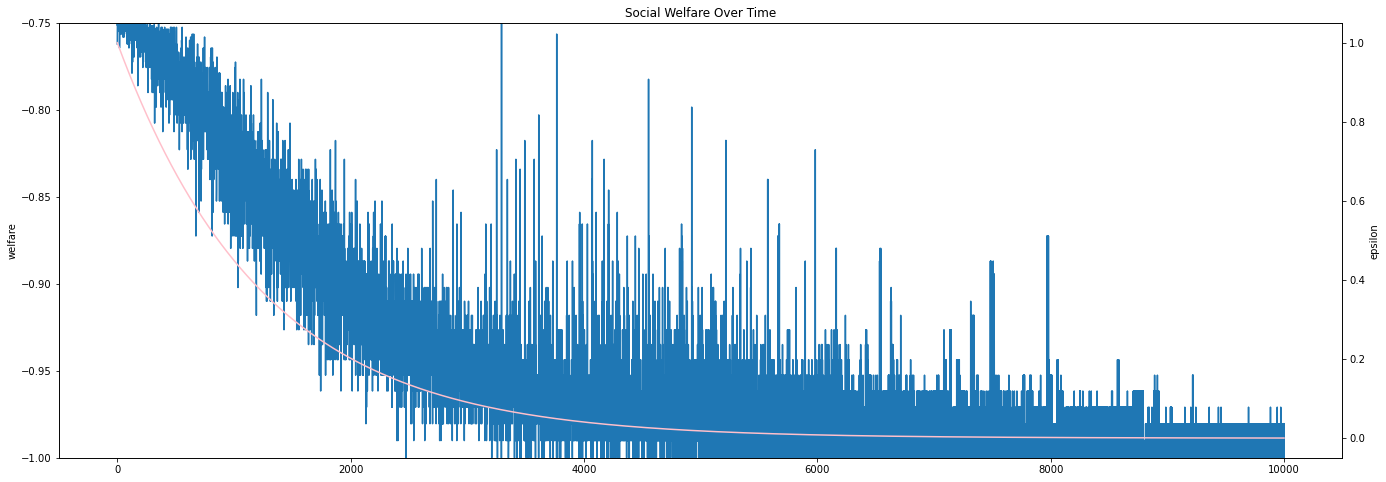

In [100]:
M, elist = run_pigou_game("DECAYED")
fig, ax = plt.subplots(figsize=(23,8))
ax.plot([M[t]["R"].mean() for t in M.keys()])
ax2=ax.twinx()
ax2.plot(elist, color='pink')
ax2.set_ylabel("epsilon")
plt.title("Social Welfare Over Time")
plt.xlabel("iteration")
ax.set_ylabel("welfare")
ax.set_ylim((-1, -0.75))

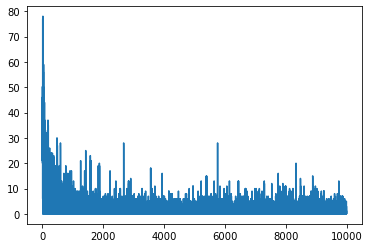

In [85]:
plt.plot([M[t]["nA"][0] for t in M.keys()])

# Scaling Players

In [8]:
def run_braess_game(EPSILON=0, N_AGENTS=100):
    Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)
    # Q = np.random.random((N_AGENTS, N_STATES, N_ACTIONS)) * 2

    ALPHA = np.random.random_sample(size=N_AGENTS)

    if EPSILON == "DECAYED":
        EPS_START = 1
        EPS_END = 0
        EPS_DECAY = N_ITER/8
    else:
        EPS_START = EPSILON
        EPS_END = EPSILON
        EPS_DECAY = N_ITER/8

    M = {}
    ind = np.arange(N_AGENTS)
    S = np.random.randint(N_STATES, size=N_AGENTS)
    R = np.ones(N_AGENTS) * -2
    A = np.random.randint(N_STATES, size=N_AGENTS)

    elist = []

    for t in range(N_ITER):

        EPSILON = (EPS_END + (EPS_START - EPS_END) * math.exp(-1. * t / EPS_DECAY)) # if t < N_ITER/10 else 0
        elist.append(EPSILON)

        A = e_greedy_select_action(Q, S, EPSILON)
        
        R, T = braess_augmented_network(A)
            
        Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)

        ### SAVE PROGRESS DATA
        M[t] = {#"nA": np.bincount(A, minlength=3),
                "R": R,
                #"Qmean": Q.mean(axis=1).mean(axis=0),
                #"groups": count_groups(Q[ind, S, :], 0.1),
                #"Qvar": Q[ind, S, :].var(axis=0),
                # "T": travel_time_per_route,
                #"sum_of_belief_updates": sum_of_belief_updates,
                #"alignment": alignment,
                #"recommendation_alignment": recommendation_alignment,
                #"action_alignment": action_alignment,
                }
    return M, elist

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 11.9 µs


In [14]:
N_AGENTS = 100000
N_STATES = 1
N_ACTIONS = 3
N_ITER = 10000

EPSILON = 0.01
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0.8
ALPHA = 0.01

QINIT = "UNIFORM" # np.array([-1.5, -1.5, -1.5])
# QINIT = np.array([2, 0])
# QINIT = np.random.random((N_AGENTS, N_STATES, N_ACTIONS)) * 2

In [16]:
%%time
M, elist = run_braess_game(EPSILON, N_AGENTS=N_AGENTS)
fig, ax = plt.subplots(figsize=(23,8))
ax.plot([M[t]["R"].mean() for t in M.keys()])
ax2=ax.twinx()
ax2.plot(elist, color='pink')
ax2.set_ylabel("epsilon")
plt.title("Social Welfare Over Time")
plt.xlabel("iteration")
ax.set_ylabel("welfare")
#ax.set_ylim((-1, -0.75))

KeyboardInterrupt: 

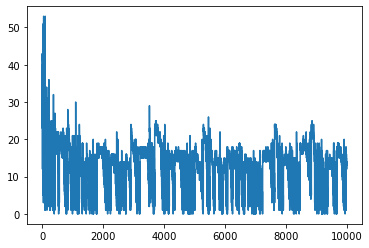

In [112]:
plt.plot([M[t]["nA"][0] for t in M.keys()])

In [ ]:
results_dict = {}

In [133]:
x_values = np.array([10, 100, 1000, 10000, 100000])

for x in tqdm(x_values):
    if x not in results_dict.keys():
        repetitions = {}
        for i in range(10):
            M, elist = run_braess_game(EPSILON=EPSILON, N_AGENTS=x)
            repetitions[i] = np.array([M[t]["R"].mean() for t in M.keys()])
        results_dict[x] = repetitions

  0%|          | 0/5 [00:00<?, ?it/s]

In [2]:
path = "dynamics_results"
name = "braess-learning_player-sweep_alpha01_epsilon05"

In [135]:
ind1, ind2 = -5000, -1
means = np.array([np.array([x[ind1:ind2].mean() for x in dictionary.values()]).mean() for dictionary in results_dict.values()])
q25 = np.array([np.percentile(np.array([x[ind1:ind2].mean() for x in dictionary.values()]), 25) for dictionary in results_dict.values()])
q75 = np.array([np.percentile(np.array([x[ind1:ind2].mean() for x in dictionary.values()]), 75) for dictionary in results_dict.values()])

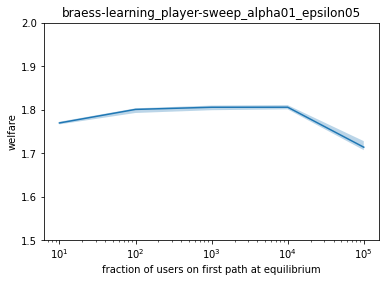

In [137]:
plt.plot(x_values, -means)
plt.fill_between(x_values, -q25, -q75, alpha=0.3)
plt.title(name)
plt.ylabel("welfare")
plt.xlabel("fraction of users on first path at equilibrium")
plt.xscale("log")
plt.ylim((1.5, 2))
plt.savefig(f"{path}/welfare_{name}.png")

In [138]:
with open(f"dynamics_results/{name}", "wb") as file:
    pickle.dump(results_dict, file)

In [3]:
with open(f"{path}/{name}", "rb") as file:
    results_dict = pickle.load(file)

# Public Goods Game

In [28]:
def public_goods_game(A, n_actions, multiplier=1.2):
    n_players = len(A)
    pot_total = (np.sum(A) * multiplier)/(n_actions-1)
    R = pot_total/n_players - A/(n_actions-1)
    return R, (np.ones(n_players)*int((pot_total)/n_players)).astype(int)

In [61]:
%%time
def run_public_goods_game(multiplier=1.2, EPSILON=0, N_AGENTS=10, N_ACTIONS=3, N_STATES=3):
    # Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)
    Q = np.random.random((N_AGENTS, N_STATES, N_ACTIONS))

    ALPHA = np.random.random_sample(size=N_AGENTS)

    if EPSILON == "DECAYED":
        EPS_START = 1
        EPS_END = 0
        EPS_DECAY = N_ITER/8
    else:
        EPS_START = EPSILON
        EPS_END = EPSILON
        EPS_DECAY = N_ITER/8

    M = {}
    ind = np.arange(N_AGENTS)
    S = np.random.randint(N_STATES, size=N_AGENTS)
    R = np.ones(N_AGENTS) * -2
    A = np.random.randint(N_ACTIONS, size=N_AGENTS)

    elist = []

    for t in range(N_ITER):

        EPSILON = (EPS_END + (EPS_START - EPS_END) * math.exp(-1. * t / EPS_DECAY)) # if t < N_ITER/10 else 0
        elist.append(EPSILON)

        A = e_greedy_select_action(Q, S, EPSILON)
        
        R, S = public_goods_game(A, n_actions=N_ACTIONS, multiplier=multiplier)

        Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)

        ### SAVE PROGRESS DATA
        M[t] = {"nA": np.bincount(A, minlength=N_ACTIONS),
                "R": R,
                "Qmean": Q.mean(axis=1).mean(axis=0),
                #"groups": count_groups(Q[ind, S, :], 0.1),
                "Qvar": Q[ind, S, :].var(axis=0),
                #"nA": np.bincount(A, minlength=3),
                # "T": travel_time_per_route,
                "sum_of_belief_updates": sum_of_belief_updates,
                #"alignment": alignment,
                #"recommendation_alignment": recommendation_alignment,
                #"action_alignment": action_alignment,
                }
    return M, elist

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 8.11 µs


In [88]:
N_AGENTS = 6
N_STATES = 10
N_ACTIONS = N_STATES
N_ITER = 10000

EPSILON = 0.3
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0.8
ALPHA = 0.01

QINIT = "UNIFORM" # np.array([-1.5, -1.5, -1.5])
# QINIT = np.array([2, 0])
# QINIT = np.random.random((N_AGENTS, N_STATES, N_ACTIONS)) * 2

 - multiplier can not be greater than the number of states (for state representation to work)
 - when multiplier is equal or greater than the number of players, the nash equilibrium becomes to contribute everything

Text(0, 0.5, 'welfare')

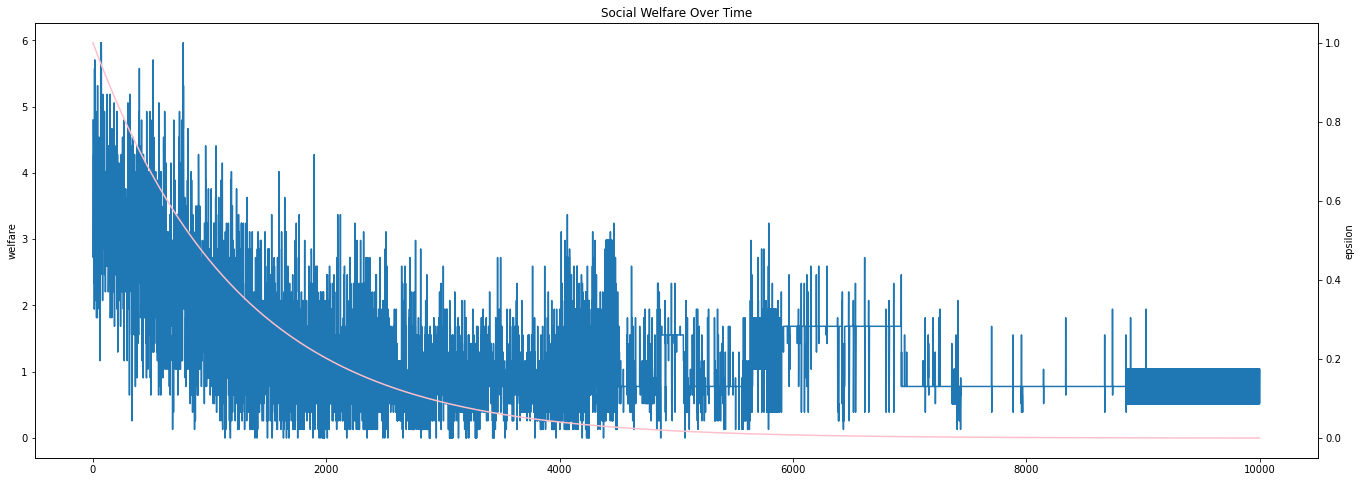

In [95]:
M, elist = run_public_goods_game(multiplier=8, EPSILON="DECAYED", N_AGENTS=N_AGENTS, N_ACTIONS=N_ACTIONS, N_STATES=N_STATES)
fig, ax = plt.subplots(figsize=(23,8))
ax.plot([M[t]["R"].mean() for t in M.keys()])
ax2=ax.twinx()
ax2.plot(elist, color='pink')
ax2.set_ylabel("epsilon")
plt.title("Social Welfare Over Time")
plt.xlabel("iteration")
ax.set_ylabel("welfare")
# ax.set_ylim((-0.2, 0.2))

In [38]:
np.mean([M[t]["R"].mean() for t in M.keys()])/0.2

3.761583333333332

In [350]:
results_dict = {}

In [361]:
x_values = np.arange(2, 10)
y_values = np.arange(2, 10)

for x in tqdm(x_values):
    for y in tqdm(y_values):
        #if x not in results_dict.keys():
        repetitions = {}
        for i in range(10):
            M, elist = run_public_goods_game(0.01, x, y, y)
            repetitions[i] = np.array([M[t]["R"].mean() for t in M.keys()])
        results_dict[(x,y)] = repetitions

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [6]:
image = np.zeros((8,8))
for k, v in results_dict.items():
    image[k[0]-2, k[1]-2] = np.mean([ts.mean() for ts in v.values()])/0.2

In [7]:
image

array([[0.010105  , 0.00648   , 0.01963667, 0.02720875, 0.021444  ,
        0.00872333, 0.00797714, 0.02042625],
       [0.00541   , 0.00616667, 0.00634444, 0.00788917, 0.01268867,
        0.00648333, 0.00766857, 0.00939375],
       [0.0054375 , 0.0057575 , 0.0061225 , 0.00717375, 0.009308  ,
        0.00778208, 0.00870143, 0.00783031],
       [0.005416  , 0.005713  , 0.00629333, 0.009935  , 0.0066812 ,
        0.009881  , 0.00852743, 0.00761175],
       [0.00525   , 0.00562417, 0.00603389, 0.00610625, 0.00733967,
        0.00651333, 0.00738262, 0.00742312],
       [0.00532571, 0.00773786, 0.00595905, 0.00616071, 0.00656257,
        0.00726476, 0.00769102, 0.00737107],
       [0.00651375, 0.00564   , 0.0088425 , 0.00621781, 0.0062125 ,
        0.00684854, 0.00901857, 0.01498156],
       [0.00534556, 0.00565667, 0.00570889, 0.00620389, 0.00650444,
        0.00735093, 0.00751492, 0.00712722]])

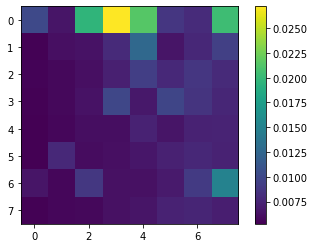

In [8]:
plt.imshow(image)
plt.colorbar()

In [70]:
path = "dynamics_results"
name = "public-learning_multiplier-sweep_alpha01_epsilonDECAYED"

In [68]:
results_dict = {}

In [69]:
x_values = np.linspace(1, 4, 21)

for x in tqdm(x_values):
    repetitions = {}
    for i in range(10):
        M, elist = run_public_goods_game(multiplier=x, EPSILON="DECAYED", N_AGENTS=4, N_ACTIONS=10, N_STATES=10)
        repetitions[i] = np.array([M[t]["R"].mean() for t in M.keys()])
    results_dict[x] = repetitions

  0%|          | 0/21 [00:00<?, ?it/s]

In [71]:
ind1, ind2 = -5000, -1
means = np.array([np.array([x[ind1:ind2].mean() for x in dictionary.values()]).mean() for dictionary in results_dict.values()])
q25 = np.array([np.percentile(np.array([x[ind1:ind2].mean() for x in dictionary.values()]), 25) for dictionary in results_dict.values()])
q75 = np.array([np.percentile(np.array([x[ind1:ind2].mean() for x in dictionary.values()]), 75) for dictionary in results_dict.values()])

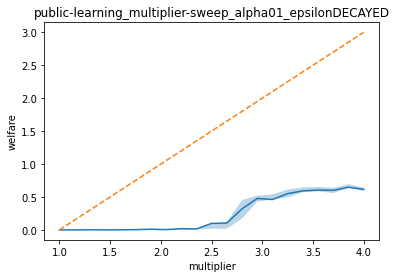

In [77]:
plt.plot(x_values, means)
plt.plot(x_values, x_values-1, ls="--")
plt.fill_between(x_values, q25, q75, alpha=0.3)
plt.title(name)
plt.ylabel("welfare")
plt.xlabel("multiplier")
#plt.xscale("log")
#plt.ylim((1.5, 2))
plt.savefig(f"{path}/welfare_{name}.png")

In [74]:
with open(f"dynamics_results/{name}", "wb") as file:
    pickle.dump(results_dict, file)

In [5]:
with open(f"{path}/{name}", "rb") as file:
    results_dict = pickle.load(file)